In [1]:
#install ase to be able to read the geo file
!pip install ase
!pip install tqdm

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax_md import space,simulate,quantity
import matplotlib.pyplot as plt
from ase.io import read
from jax_md.reaxff.reaxff_interactions import reaxff_inter_list
from jax_md.reaxff.reaxff_helper import read_force_field
from jax_md.reaxff.reaxff_forcefield import ForceField
from tqdm import tqdm

In [3]:
# control variables
TYPE = jnp.float64
ff_path = "data/ffield"
cutoff2 = 0.001
geo_path = "data/geo.pdb"
solver_iter_count = 200
solver_tol = 1e-8
MD_count = 1000
reax_time = 0.2 # timestep in fs

In [4]:
# read and preprocess the force field
force_field = read_force_field(ff_path, cutoff2 = cutoff2, dtype=TYPE)
force_field = ForceField.fill_off_diag(force_field)
force_field = ForceField.fill_symm(force_field)

In [5]:
# read the geometry file
struct = read(geo_path)
struct.set_positions(struct.get_positions())
pos = struct.get_positions()
pos = pos - onp.min(pos,axis=0)
struct.set_positions(pos)   

R = jnp.array(struct.positions,dtype=TYPE)

types = struct.get_chemical_symbols()
types_int = [force_field.name_to_index[t] for t in types]
species = jnp.array(types_int)
atomic_nums = jnp.array(struct.get_atomic_numbers())
box_size = jnp.array(struct.cell.lengths(),dtype=TYPE)
N = len(R)

In [6]:
print(f"Number of atoms: {N}")
print(f"Box size: {box_size}")

Number of atoms: 300
Box size: [94.4285 94.4285 94.4285]


In [7]:
# setup reaxff
displacement, shift = space.periodic(box_size)
reaxff_inter_fn, energy_fn = reaxff_inter_list(displacement,
                                            box_size,
                                            species,atomic_nums,
                                            force_field,
                                            tol=solver_tol,
                                            solver_model='EEM',
                                            backprop_solve=False,
                                            tors_2013=False,
                                            max_solver_iter=solver_iter_count,
                                            short_inters_capacity_multiplier=1.5
                                            )

In [8]:
nbrs = reaxff_inter_fn.allocate(R)
mass = force_field.amas[species]
mass = jnp.array(mass, dtype=TYPE).reshape(-1,1)
# required conversion for timestep to match reaxff timestep
base_time = 48.8882129 
multip = reax_time/base_time
# initalize the NVE simulation
init_fn, apply_fn = simulate.nve(energy_fn, shift, multip) #4.184e-3
state = init_fn(jax.random.PRNGKey(0), R, kT=1e-8, mass=mass, nbr_lists=nbrs)

# MD step function
@jax.jit
def body_fn(i, state):
  state, nbrs = state
  nbrs = reaxff_inter_fn.update(state.position, nbrs)
  state = apply_fn(state, nbr_lists=nbrs)
  return state, nbrs

In [9]:
# run the MD
PE = []
KE = []
step = 0
data_collect_freq = 10
pbar = tqdm(total = MD_count)
while step < MD_count:
    new_state, nbrs  = body_fn(step, (state, nbrs))
    if nbrs.did_buffer_overflow == True:
        print("overflow step: ", step)
        print('Neighbor list overflowed, reallocating.')
        nbrs = reaxff_inter_fn.allocate(state.position)
    else:
        if step % data_collect_freq == 0:
            p_energy = jax.jit(energy_fn)(state.position, nbrs)
            k_energy = jax.jit(quantity.kinetic_energy)(velocity=state.velocity, mass=state.mass)
            PE += [p_energy]
            KE += [k_energy]
        state = new_state
        pbar.update(1)
        step += 1


PE = onp.array(PE)
KE = onp.array(KE)
total = PE + KE

 35%|█████████████████████▊                                         | 346/1000 [01:16<02:37,  4.16it/s]

overflow step:  349
Neighbor list overflowed, reallocating.


100%|██████████████████████████████████████████████████████████████▊| 997/1000 [03:35<00:00,  4.44it/s]

In [16]:
target_energy = onp.loadtxt("data/reaxff_target.txt")
target_PE = target_energy[:,0][::data_collect_freq]
target_KE = target_energy[:,1][::data_collect_freq]

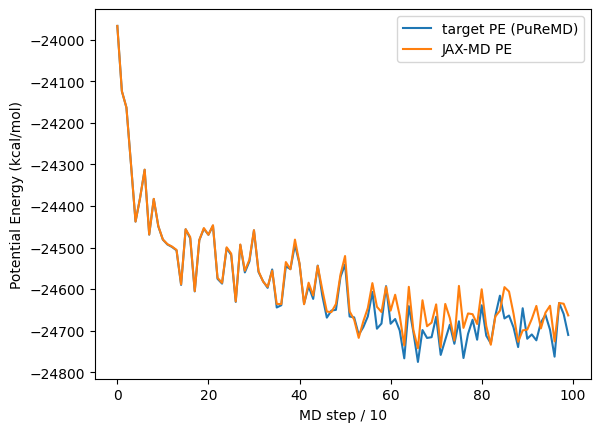

In [20]:
plt.plot(target_PE, label="target PE (PuReMD)")
plt.plot(PE, label="JAX-MD PE")
plt.ylabel("Potential Energy (kcal/mol)")
plt.xlabel(f"MD step / {data_collect_freq}")
plt.legend()